In [1]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn.calibration import calibration_curve

import pandas as pd
import numpy as np
import os
from sklearn.utils import resample

In [282]:
# 设置全局字体大小
plt.rcParams.update({'font.size': 14})  # 修改这里的数字来调整字体大小
plt.rcParams['figure.facecolor'] = 'white'  # 设置画板背景为白色
plt.rcParams['axes.facecolor'] = 'white'  # 设置坐标轴背景为白色

# 二分类情况的函数
def read_data_binary(file_list, label_list):
    data_dict = {}
    for file, label in zip(file_list, label_list):
        df = pd.read_csv(file)
        data_dict[label] = {
            'y_true': df['y_true'],
            'y_pred': df['y_pred_prob_0']
        }
    return data_dict

def compute_roc_prc_binary(data):
    roc_data = {}
    prc_data = {}
    
    for model, df in data.items():
        fpr, tpr, _ = roc_curve(df['y_true'], df['y_pred'])
        precision, recall, _ = precision_recall_curve(df['y_true'], df['y_pred'])
        roc_data[model] = (fpr, tpr)
        prc_data[model] = (precision, recall)
        
    return roc_data, prc_data

# 多分类情况的函数
def read_data_multiclass(file_list, label_list, num_classes):
    data_dict = {}
    for file, label in zip(file_list, label_list):
        df = pd.read_csv(file)
        data_dict[label] = {
            'y_true': df['y_true'],
            'y_pred': df[[f'y_pred_prob_{i}' for i in range(num_classes)]].values
        }
    return data_dict

def compute_roc_prc_multiclass(data):
    roc_data = {}
    prc_data = {}
    
    for model, df in data.items():
        fpr = {}
        tpr = {}
        precision = {}
        recall = {}
        for i in range(df['y_pred'].shape[1]):  # Assuming one column per class
            fpr[i], tpr[i], _ = roc_curve((df['y_true'] == i).astype(int), df['y_pred'][:, i])
            precision[i], recall[i], _ = precision_recall_curve((df['y_true'] == i).astype(int), df['y_pred'][:, i])
        roc_data[model] = fpr, tpr
        prc_data[model] = precision, recall
        
    return roc_data, prc_data

# 二分类情况的绘图函数
def plot_roc_prc_binary(roc_data, prc_data, data):
    plt.figure(figsize=(11, 5))

    # ROC Curve
    plt.subplot(1, 2, 1)
    for model, (fpr, tpr) in roc_data.items():
        plt.plot(fpr, tpr, label=f'{model} ({auc(fpr, tpr) * 100:.1f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(fontsize='small')  # 调整图例的字体大小
    plt.grid(True)

    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    for model, (precision, recall) in prc_data.items():
        plt.plot(recall, precision, label=f'{model} ({average_precision_score(data[model]["y_true"], data[model]["y_pred"]) * 100:.1f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(fontsize='small')  # 调整图例的字体大小
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 多分类情况的绘图函数
def plot_roc_prc_multiclass(roc_data, prc_data, num_classes, data, class_name):
    plt.figure(figsize=(10, num_classes * 6))  # 调整图形大小以适应所有子图

    # 绘制每个类别的 ROC 和 PRC
    for i in range(num_classes):
        # ROC Curve for each class
        plt.subplot(num_classes + 1, 2, 2*i+1)  # 注意这里的改动，增加了额外的行
        for model, (fpr, tpr) in roc_data.items():
            plt.plot(fpr[i], tpr[i], label=f'{model} ({auc(fpr[i], tpr[i]) * 100:.1f})')
        plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve  ({class_name[i]})')
        plt.legend(fontsize='small')  # 调整图例的字体大小
        plt.grid(True)

        # Precision-Recall Curve for each class
        plt.subplot(num_classes + 1, 2, 2*i+2)
        for model, (precision, recall) in prc_data.items():
            plt.plot(recall[i], precision[i], label=f'{model} ({average_precision_score((data[model]["y_true"] == i).astype(int), data[model]["y_pred"][:, i]) * 100:.1f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'Precision-Recall Curve ({class_name[i]})')
        plt.legend(fontsize='small')  # 调整图例的字体大小
        plt.grid(True)

    # 绘制宏平均的 ROC
    plt.subplot(num_classes + 1, 2, num_classes * 2 + 1)
    for model, (fpr, tpr) in roc_data.items():
        # 计算宏平均的 FPR, TPR
        mean_fpr = np.linspace(0, 1, 100)
        mean_tpr = np.mean([np.interp(mean_fpr, fpr[i], tpr[i]) for i in range(num_classes)], axis=0)
        plt.plot(mean_fpr, mean_tpr, label=f'{model} (macro AUC = {auc(mean_fpr, mean_tpr):.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Macro-average ROC Curve')
    plt.legend(fontsize='small')  # 调整图例的字体大小
    plt.grid(True)

    plt.tight_layout()
    plt.show()

import warnings
from sklearn.exceptions import UndefinedMetricWarning

# 二分类情况的 compile_results 函数，包括 bootstrap 置信区间
def compile_results_binary(data, n_bootstraps=1000):
    results = {}
    for model, df in data.items():
        # Initialize lists to store bootstrap results
        bootstrapped_auroc = []
        bootstrapped_auprc = []
        bootstrapped_accuracy = []
        bootstrapped_recall = []
        bootstrapped_precision = []
        bootstrapped_f1 = []

        # Bootstrap loop
        for _ in range(n_bootstraps):
            indices = resample(np.arange(len(df['y_true'])))
            y_true_boot = df['y_true'].iloc[indices]
            y_pred_boot = df['y_pred'].iloc[indices]

            # Find the optimal threshold
            precision, recall, thresholds = precision_recall_curve(y_true_boot, y_pred_boot)
            f1_scores = np.where((recall + precision) > 0, 2 * recall * precision / (recall + precision), 0)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 1.0
            y_pred_optimal = (y_pred_boot > optimal_threshold).astype(int)

            # Calculate metrics at the optimal threshold
            bootstrapped_auroc.append(roc_auc_score(y_true_boot, y_pred_boot))
            bootstrapped_auprc.append(average_precision_score(y_true_boot, y_pred_boot))
            bootstrapped_accuracy.append(accuracy_score(y_true_boot, y_pred_optimal))
            bootstrapped_recall.append(recall_score(y_true_boot, y_pred_optimal))
            bootstrapped_precision.append(precision_score(y_true_boot, y_pred_optimal))
            bootstrapped_f1.append(f1_score(y_true_boot, y_pred_optimal))

        # Calculate metrics using the entire dataset
        y_true = df['y_true']
        y_pred = df['y_pred']
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        f1_scores = np.where((recall + precision) > 0, 2 * recall * precision / (recall + precision), 0)
        optimal_idx = np.argmax(f1_scores)
        optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 1.0
        y_pred_optimal = (y_pred > optimal_threshold).astype(int)

        results[model] = {
            'AUROC': (roc_auc_score(y_true, y_pred), np.percentile(bootstrapped_auroc, [2.5, 97.5])),
            'AUPRC': (average_precision_score(y_true, y_pred), np.percentile(bootstrapped_auprc, [2.5, 97.5])),
            'Accuracy': (accuracy_score(y_true, y_pred_optimal), np.percentile(bootstrapped_accuracy, [2.5, 97.5])),
            'Recall': (recall_score(y_true, y_pred_optimal), np.percentile(bootstrapped_recall, [2.5, 97.5])),
            'Precision': (precision_score(y_true, y_pred_optimal), np.percentile(bootstrapped_precision, [2.5, 97.5])),
            'F1': (f1_score(y_true, y_pred_optimal), np.percentile(bootstrapped_f1, [2.5, 97.5]))
        }

    return results

# 多分类情况的 compile_results 函数，包括 bootstrap 置信区间
from sklearn.metrics import roc_auc_score, average_precision_score, accuracy_score, recall_score, precision_score, f1_score
from sklearn.utils import resample
from sklearn.metrics import precision_recall_curve

# def compile_results_multiclass(data, num_classes, n_bootstraps=1000):
#     results = {}
#     for model, df in data.items():
#         model_results = {}
#         # 初始化宏平均的指标列表
#         macro_scores = {
#             'AUROC': [],
#             'AUPRC': [],
#             'Accuracy': [],
#             'Recall': [],
#             'Precision': [],
#             'F1': []
#         }

#         for i in range(num_classes):
#             # Bootstrap
#             bootstrapped_scores = {
#                 'AUROC': [],
#                 'AUPRC': [],
#                 'Accuracy': [],
#                 'Recall': [],
#                 'Precision': [],
#                 'F1': []
#             }

#             for _ in range(n_bootstraps):
#                 indices = resample(np.arange(len(df['y_true'])))
#                 y_true_boot = df['y_true'][indices]
#                 y_pred_boot = df['y_pred'][indices, i]

#                 # Find the optimal threshold
#                 precision, recall, thresholds = precision_recall_curve((y_true_boot == i).astype(int), y_pred_boot)
#                 f1_scores = np.where((recall + precision) > 0, 2 * recall * precision / (recall + precision), 0)
#                 optimal_idx = np.argmax(f1_scores)
#                 optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 1.0

#                 # Calculate metrics at the optimal threshold
#                 y_pred_optimal = (y_pred_boot > optimal_threshold).astype(int)
#                 bootstrapped_scores['AUROC'].append(roc_auc_score((y_true_boot == i).astype(int), y_pred_boot))
#                 bootstrapped_scores['AUPRC'].append(average_precision_score((y_true_boot == i).astype(int), y_pred_boot))
#                 bootstrapped_scores['Accuracy'].append(accuracy_score((y_true_boot == i).astype(int), y_pred_optimal))
#                 bootstrapped_scores['Recall'].append(recall_score((y_true_boot == i).astype(int), y_pred_optimal))
#                 bootstrapped_scores['Precision'].append(precision_score((y_true_boot == i).astype(int), y_pred_optimal))
#                 bootstrapped_scores['F1'].append(f1_score((y_true_boot == i).astype(int), y_pred_optimal))

#             # Calculate metrics using the entire dataset
#             y_true = (df['y_true'] == i).astype(int)
#             y_pred = df['y_pred'][:, i]
#             precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
#             f1_scores = np.where((recall + precision) > 0, 2 * recall * precision / (recall + precision), 0)
#             optimal_idx = np.argmax(f1_scores)
#             optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 1.0
#             y_pred_optimal = (y_pred > optimal_threshold).astype(int)

#             class_results = {
#                 'AUROC': roc_auc_score(y_true, y_pred),
#                 'AUPRC': average_precision_score(y_true, y_pred),
#                 'Accuracy': accuracy_score(y_true, y_pred_optimal),
#                 'Recall': recall_score(y_true, y_pred_optimal),
#                 'Precision': precision_score(y_true, y_pred_optimal),
#                 'F1': f1_score(y_true, y_pred_optimal)
#             }
#             model_results[f'Class {i}'] = class_results

#             # 累加宏平均的指标
#             for key in macro_scores:
#                 macro_scores[key].append(class_results[key])

#         # 计算宏平均的指标
#         macro_results = {
#             metric: np.mean(values)
#             for metric, values in macro_scores.items()
#         }
#         model_results['Macro Average'] = macro_results

#         results[model] = model_results
#     return results


def compile_results_multiclass(data, num_classes, n_bootstraps=1000):
    results = {}
    for model, df in data.items():
        model_results = {}
        # 初始化宏平均的指标列表
        macro_scores = {
            'AUROC': [],
            'AUPRC': [],
            'Accuracy': [],
            'Recall': [],
            'Precision': [],
            'F1': []
        }

        for i in range(num_classes):
            # Bootstrap
            bootstrapped_scores = {
                'AUROC': [],
                'AUPRC': [],
                'Accuracy': [],
                'Recall': [],
                'Precision': [],
                'F1': []
            }

            for _ in range(n_bootstraps):
                indices = resample(np.arange(len(df['y_true'])))
                y_true_boot = df['y_true'][indices]
                y_pred_boot = df['y_pred'][indices, i]

                # Find the optimal threshold
                precision, recall, thresholds = precision_recall_curve((y_true_boot == i).astype(int), y_pred_boot)
                f1_scores = np.where((recall + precision) > 0, 2 * recall * precision / (recall + precision), 0)
                optimal_idx = np.argmax(f1_scores)
                optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 1.0

                # Calculate metrics at the optimal threshold
                y_pred_optimal = (y_pred_boot > optimal_threshold).astype(int)
                bootstrapped_scores['AUROC'].append(roc_auc_score((y_true_boot == i).astype(int), y_pred_boot))
                bootstrapped_scores['AUPRC'].append(average_precision_score((y_true_boot == i).astype(int), y_pred_boot))
                bootstrapped_scores['Accuracy'].append(accuracy_score((y_true_boot == i).astype(int), y_pred_optimal))
                bootstrapped_scores['Recall'].append(recall_score((y_true_boot == i).astype(int), y_pred_optimal))
                bootstrapped_scores['Precision'].append(precision_score((y_true_boot == i).astype(int), y_pred_optimal))
                bootstrapped_scores['F1'].append(f1_score((y_true_boot == i).astype(int), y_pred_optimal))

            # Calculate metrics using the entire dataset
            y_true = (df['y_true'] == i).astype(int)
            y_pred = df['y_pred'][:, i]
            precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
            f1_scores = np.where((recall + precision) > 0, 2 * recall * precision / (recall + precision), 0)
            optimal_idx = np.argmax(f1_scores)
            optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 1.0
            y_pred_optimal = (y_pred > optimal_threshold).astype(int)

            class_results = {
                'AUROC': (roc_auc_score(y_true, y_pred), np.percentile(bootstrapped_scores['AUROC'], [2.5, 97.5])),
                'AUPRC': (average_precision_score(y_true, y_pred), np.percentile(bootstrapped_scores['AUPRC'], [2.5, 97.5])),
                'Accuracy': (accuracy_score(y_true, y_pred_optimal), np.percentile(bootstrapped_scores['Accuracy'], [2.5, 97.5])),
                'Recall': (recall_score(y_true, y_pred_optimal), np.percentile(bootstrapped_scores['Recall'], [2.5, 97.5])),
                'Precision': (precision_score(y_true, y_pred_optimal), np.percentile(bootstrapped_scores['Precision'], [2.5, 97.5])),
                'F1': (f1_score(y_true, y_pred_optimal), np.percentile(bootstrapped_scores['F1'], [2.5, 97.5]))
            }
            model_results[f'Class {i}'] = class_results

            # 累加宏平均的指标
            for key in macro_scores:
                macro_scores[key].append(class_results[key][0])  # Only take the point estimate for macro averaging

        # 计算宏平均的指标
        macro_results = {
            metric: (np.mean(values), np.percentile(values, [2.5, 97.5]))
            for metric, values in macro_scores.items()
        }
        model_results['Macro Average'] = macro_results

        results[model] = model_results
    return results

In [376]:
root_path = "/home/luojiawei/EMR_LIP/结果文件夹/模型性能_share"

# file_list = ["test_lstm_mimic_death_1d.csv","test_biattlstm_mimic_death_1d.csv",
#              "test_lstm_mimic_death_2d.csv","test_biattlstm_mimic_death_2d.csv",
#              "test_lstm_mimic_death_4d.csv","test_biattlstm_mimic_death_4d.csv",
#              "test_lstm_mimic_death_7d.csv","test_biattlstm_mimic_death_7d.csv",
#              "test_lstm_mimic_hospital_expire_flag.csv","test_biattlstm_mimic_hospital_expire_flag.csv",
#              "test_lstm_mimic_icu_los_1d.csv","test_biattlstm_mimic_icu_los_1d.csv",
#              "test_lstm_mimic_death_1d.csv","test_biattlstm_mimic_death_1d.csv",
#              "test_lstm_mimic_death_2d.csv","test_biattlstm_mimic_death_2d.csv",
#              "test_lstm_mimic_death_4d.csv","test_biattlstm_mimic_death_4d.csv",
#              "test_lstm_mimic_death_7d.csv","test_biattlstm_mimic_death_7d.csv",
#              "test_lstm_mimic_hospital_expire_flag.csv","test_biattlstm_mimic_hospital_expire_flag.csv",
#              "test_lstm_mimic_los_icu_1d.csv","test_biattlstm_mimic_los_icu_1d.csv"]
# file_list = ["test_lstm_eicu_death_1d.csv","test_biattlstm_eicu_death_1d.csv",
#              "test_lstm_eicu_death_2d.csv","test_biattlstm_eicu_death_2d.csv",
#              "test_lstm_eicu_death_4d.csv","test_biattlstm_eicu_death_4d.csv",
#              "test_lstm_eicu_death_7d.csv","test_biattlstm_eicu_death_7d.csv",
#              "test_lstm_eicu_hospitaldischargestatus.csv","test_biattlstm_eicu_hospitaldischargestatus.csv",
#              "test_lstm_eicu_icu_los_1d.csv","test_biattlstm_eicu_icu_los_1d.csv",
#              "test_lstm_eicu_death_1d.csv","test_biattlstm_eicu_death_1d.csv",
#              "test_lstm_eicu_death_2d.csv","test_biattlstm_eicu_death_2d.csv",
#              "test_lstm_eicu_death_4d.csv","test_biattlstm_eicu_death_4d.csv",
#              "test_lstm_eicu_death_7d.csv","test_biattlstm_eicu_death_7d.csv",
#              "test_lstm_eicu_hospitaldischargestatus.csv","test_biattlstm_eicu_hospitaldischargestatus.csv",
#              "test_lstm_eicu_los_icu_1d.csv","test_biattlstm_eicu_los_icu_1d.csv"]
# label_list = ["LSTM 1-day mortality", "AttBiLSTM 1-day mortality", 
#               "LSTM 2-day mortality", "AttBiLSTM 2-day mortality", 
#               "LSTM 4-day mortality", "AttBiLSTM 4-day mortality", 
#               "LSTM 7-day mortality", "AttBiLSTM 7-day mortality", 
#               "LSTM in-hospital mortality", "AttBiLSTM in-hospital mortality", 
#               "LSTM ICU LoS > 2d", "AttBiLSTM ICU LoS > 2d"]

# file_list = ["test_lstm_mimic_death_24h_dym.csv",
#              "test_biattlstm_mimic_death_24h_dym.csv",
#              "test_lstm_eicu_death_24h_dym.csv",
#              "test_biattlstm_eicu_death_24h_dym.csv"]
# label_list = ["LSTM mimic death_24h", "AttBiLSTM  mimic death_24h", 
#               "LSTM eicu death_24h", "AttBiLSTM  eicu death_24h"]

file_list = ["test_lstm_eicu_to_eicu_hospitaldischargestatus.csv",
             "test_lstm_eicu_to_mimic_hospitaldischargestatus.csv",
            #  "test_lstm_eicu_to_mimic_hospitaldischargestatus_no.csv",
             "test_lstm_mimic_to_eicu_hospital_expire_flag.csv",
            #  "test_lstm_mimic_to_eicu_hospital_expire_flag_no.csv",
             "test_lstm_mimic_to_mimic_hospital_expire_flag.csv"
             ]

# file_list = ["test_lstm_eicu_to_eicu_death_24h_dym.csv",
#              "test_lstm_eicu_to_mimic_death_24h_dym.csv",
#             #  "test_lstm_eicu_to_mimic_death_24h_dym_no.csv",
#              "test_lstm_mimic_to_eicu_death_24h_dym.csv",
#             #  "test_lstm_mimic_to_eicu_death_24h_dym_no.csv",
#              "test_lstm_mimic_to_mimic_death_24h_dym.csv"
#              ]
label_list = ["eICU-CRD to eICU-CRD (Y)",
              "eICU-CRD to MIMIC-IV (Y)",
            #   "eICU-CRD to MIMIC-IV (N)",
              "MIMIC-IV to eICU-CRD (Y)",
            #   "MIMIC-IV to eICU-CRD (N)",
              "MIMIC-IV to MIMIC-IV (Y)"]



file_list = [os.path.join(root_path, f) for f in file_list]


In [377]:
datas = read_data_binary(file_list, label_list)

In [378]:
roc_data, prc_data = compute_roc_prc_binary(datas)

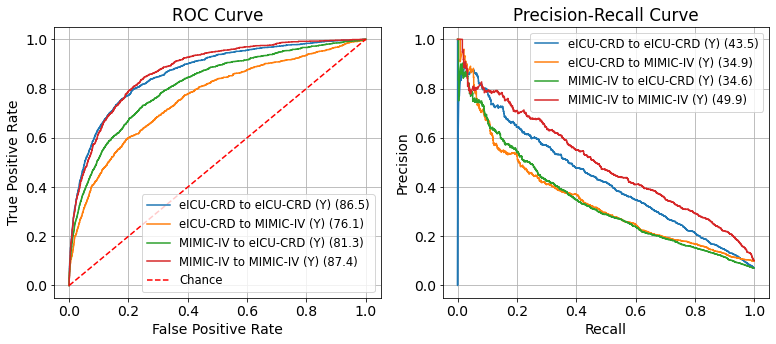

In [379]:
plot_roc_prc_binary(roc_data, prc_data, datas)

In [380]:
results = compile_results_binary(datas, n_bootstraps=50)

/home/luojiawei/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide
/home/luojiawei/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide
/home/luojiawei/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide
/home/luojiawei/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide
/home/luojiawei/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide
/home/luojiawei/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: invalid value encountered in true_divide
/home/luojiawei/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:152: RuntimeWarning: inval

In [381]:
# 将结果字典转换为 DataFrame
data_rows = []
for model, metrics in results.items():
    row = {'model': model}
    for metric, (point_estimate, ci) in metrics.items():
        point_estimate *= 100
        ci = [x * 100 for x in ci]
        row[metric] = f"{point_estimate:.1f} ({ci[0]:.1f}, {ci[1]:.1f})"
    data_rows.append(row)

df = pd.DataFrame(data_rows)

# 如果你希望 'model' 是第一列，可以选择性地重新排序列
df = df[['model'] + [col for col in df if col != 'model']]

In [384]:
df

,model,AUROC,AUPRC,Accuracy,Recall,Precision,F1
0,eICU-CRD to eICU-CRD (Y),"86.5 (85.7, 87.6)","43.5 (41.2, 45.8)","91.6 (90.7, 92.2)","50.3 (47.4, 55.4)","41.8 (38.6, 45.0)","45.7 (44.0, 48.0)"
1,eICU-CRD to MIMIC-IV (Y),"76.1 (74.6, 77.4)","34.9 (32.5, 38.1)","87.1 (84.4, 87.9)","40.6 (38.7, 46.6)","36.6 (30.5, 40.3)","38.5 (36.4, 41.2)"
2,MIMIC-IV to eICU-CRD (Y),"81.3 (80.1, 82.3)","34.6 (32.7, 37.0)","91.3 (87.9, 91.8)","36.9 (35.3, 51.6)","38.0 (29.8, 39.8)","37.4 (36.3, 39.8)"
3,MIMIC-IV to MIMIC-IV (Y),"87.4 (86.5, 88.3)","49.9 (47.5, 52.0)","88.5 (86.0, 89.8)","57.0 (49.6, 67.1)","43.8 (39.0, 47.9)","49.5 (47.8, 51.5)"


In [385]:
df.to_csv('/home/luojiawei/EMR_LIP/结果文件夹/性能表格_share/result_table_static_cross_test.csv', index=False)


In [198]:
import pandas as pd
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

def calculate_metrics(data, y_true, y_scores):
    # 二值化 y_true 以适应多类别情况
    y_true_binarized = label_binarize(data[y_true], classes=[0, 1, 2])
    y_score_matrix = data[y_scores].values
    auroc = roc_auc_score(y_true_binarized, y_score_matrix, multi_class='ovr')
    
    # 计算每个类别的 AUPRC 并取平均
    auprc_scores = []
    for i in range(y_score_matrix.shape[1]):
        # precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_score_matrix[:, i])
        auprc_scores.append(average_precision_score(y_true_binarized[:, i], y_score_matrix[:, i]))
    auprc = sum(auprc_scores) / len(auprc_scores)
    
    return auroc, auprc

def calculate_metrics_binary(data, y_true, y_score):
    # 对于二分类，y_score 应该是正类的预测概率
    auroc = roc_auc_score(data[y_true], data[y_score])
    
    # 计算 AUPRC
    # precision, recall, _ = precision_recall_curve(data[y_true], data[y_score])
    auprc = average_precision_score(data[y_true], data[y_score])
    
    return auroc, auprc

def calculate_metrics_binary_with_confidence(data, y_true, y_score, n_bootstraps=1000):
    auroc_scores = []
    auprc_scores = []
    
    for _ in range(n_bootstraps):
        # Bootstrap sample
        indices = np.random.randint(0, len(data), len(data))
        y_true_sample = data[y_true].iloc[indices]
        y_score_sample = data[y_score].iloc[indices]
        
        # Calculate AUROC and AUPRC
        auroc_scores.append(roc_auc_score(y_true_sample, y_score_sample))
        auprc_scores.append(average_precision_score(y_true_sample, y_score_sample))
    
    # Calculate mean and 95% confidence intervals
    auroc_mean, auroc_conf = np.mean(auroc_scores), np.percentile(auroc_scores, [2.5, 97.5])
    auprc_mean, auprc_conf = np.mean(auprc_scores), np.percentile(auprc_scores, [2.5, 97.5])
    
    return (round(auroc_mean, 3), auroc_conf.round(3)), (round(auprc_mean, 3), auprc_conf.round(3))

def calculate_metrics_with_confidence(data, y_true, y_scores, n_bootstraps=1000):
    y_true_binarized = label_binarize(data[y_true], classes=[0, 1, 2])
    y_score_matrix = data[y_scores].values
    
    auroc_scores = []
    auprc_scores = []
    
    for _ in range(n_bootstraps):
        # Bootstrap sample
        indices = np.random.randint(0, len(data), len(data))
        y_true_sample = y_true_binarized[indices]
        y_score_sample = y_score_matrix[indices]
        
        # Calculate AUROC and AUPRC for each class and average
        auroc = roc_auc_score(y_true_sample, y_score_sample, multi_class='ovr')
        auroc_scores.append(auroc)
        
        class_auprc_scores = []
        for i in range(y_score_sample.shape[1]):
            class_auprc_scores.append(average_precision_score(y_true_sample[:, i], y_score_sample[:, i]))
        auprc_scores.append(np.mean(class_auprc_scores))
    
    # Calculate mean and 95% confidence intervals
    auroc_mean, auroc_conf = np.mean(auroc_scores), np.percentile(auroc_scores, [2.5, 97.5])
    auprc_mean, auprc_conf = np.mean(auprc_scores), np.percentile(auprc_scores, [2.5, 97.5])
    
    return (round(auroc_mean, 3), auroc_conf.round(3)), (round(auprc_mean, 3), auprc_conf.round(3))

In [243]:
ds1 = pd.read_csv("/home/luojiawei/EMR_LIP/结果文件夹/模型性能/test_lstm_eicu_death_24h_dym.csv",header=0)
ds_op = pd.read_csv("/home/luojiawei/EMR_LIP_data/ds_id_eicu_crd.csv",header=0)
# ds_op = pd.read_csv("/home/luojiawei/EMR_LIP_data/ds_id_mimic_iv.csv",header=0)

In [244]:
ds1.iloc[:5]

,y_pred_prob_0,y_true,time,stid
0,0.000003,0.0,4.0,141194
1,0.000002,0.0,8.0,141194
2,0.000005,0.0,12.0,141194
3,0.000004,0.0,16.0,141194
4,0.000003,0.0,20.0,141194


In [245]:
# eicu
# 添加新列 t1 和使用 ceil 函数对 t2 取整
ds_op['t1'] = 0
ds_op['t2'] = np.ceil((ds_op['unitdischargeoffset'] - ds_op['unitadmitoffset']) / 60)

# 查看更新后的数据
ds_op.loc[:5, ["patientunitstayid", "unitadmitoffset", "unitdischargeoffset", "t1", "t2"]]

,patientunitstayid,unitadmitoffset,unitdischargeoffset,t1,t2
0,141168,0.000000,3596,0,60.0
1,141194,-0.666667,4813,0,81.0
2,141203,0.000000,1869,0,32.0
3,141208,0.000000,720,0,12.0
4,141244,-11520.000000,3835,0,256.0
5,141260,0.000000,1073,0,18.0


In [226]:
# mimic
# 添加新列 t1 和使用 ceil 函数对 t2 取整
ds_op['t1'] = 0
ds_op['t2'] = np.ceil((pd.to_datetime(ds_op['outtime']) - pd.to_datetime(ds_op['intime'])).dt.total_seconds() / 3600)

# 查看更新后的数据
ds_op.loc[:5, ["stay_id", "intime", "outtime", "t1", "t2"]]

,stay_id,intime,outtime,t1,t2
0,37067082,2157-11-20 19:18:02,2157-11-21 22:08:00,0,27.0
1,34592300,2157-12-19 15:42:24,2157-12-20 14:27:41,0,23.0
2,31205490,2110-04-11 15:52:22,2110-04-12 23:59:56,0,33.0
3,37510196,2131-01-11 04:20:05,2131-01-20 08:27:30,0,221.0
4,39060235,2160-05-18 10:00:53,2160-05-19 17:33:33,0,32.0
5,32358465,2131-03-09 21:33:00,2131-03-10 18:09:21,0,21.0


In [246]:
# 假设 ds1 和 ds_op 已经被正确加载
# 合并数据集
# merged = pd.merge(ds1, ds_op, left_on='stid', right_on='stay_id') # mimic
merged = pd.merge(ds1, ds_op, left_on='stid', right_on='patientunitstayid') # eicu

# 计算时间差
merged['time_from_start'] = merged['time'] - merged['t1']
merged['time_from_end'] = merged['time'] - merged['t2']


In [247]:
# merged.iloc[:5]

In [248]:
# 二分类情况的

# 使用新的函数计算带置信区间的指标
results_positive = {}
for t0 in range(0, 20, 4):
    filtered_data = merged[(merged['time_from_start'] > t0 - 4) & (merged['time_from_start'] <= t0 + 4)]
    (auroc, auroc_conf), (auprc, auprc_conf) = calculate_metrics_binary_with_confidence(filtered_data, 'y_true', 'y_pred_prob_0', 50)
    results_positive[t0] = {'AUROC': (round(auroc * 100, 1), (auroc_conf * 100).round(1)), 'AUPRC': (round(auprc * 100, 1), (auprc_conf * 100).round(1))}

results_negative = {}
for t0 in range(0, -20, -4):
    filtered_data = merged[(merged['time_from_end'] < t0 + 4) & (merged['time_from_end'] >= t0 - 4)]
    (auroc, auroc_conf), (auprc, auprc_conf) = calculate_metrics_binary_with_confidence(filtered_data, 'y_true', 'y_pred_prob_0', 50)
    results_negative[t0] = {'AUROC': (round(auroc * 100, 1), (auroc_conf * 100).round(1)), 'AUPRC': (round(auprc * 100, 1), (auprc_conf * 100).round(1))}


In [249]:
import pandas as pd

# 将 results_positive 转换为 DataFrame，并包括置信区间
df_positive = pd.DataFrame(list(results_positive.items()), columns=['Time from Start (minutes)', 'Metrics'])
df_positive[['AUROC', 'AUROC CI', 'AUPRC', 'AUPRC CI']] = pd.DataFrame(df_positive['Metrics'].apply(lambda x: [x['AUROC'][0], x['AUROC'][1], x['AUPRC'][0], x['AUPRC'][1]]).tolist(), index=df_positive.index)
df_positive.drop(columns=['Metrics'], inplace=True)

# 将 results_negative 转换为 DataFrame，并包括置信区间
df_negative = pd.DataFrame(list(results_negative.items()), columns=['Time to End (minutes)', 'Metrics'])
df_negative[['AUROC', 'AUROC CI', 'AUPRC', 'AUPRC CI']] = pd.DataFrame(df_negative['Metrics'].apply(lambda x: [x['AUROC'][0], x['AUROC'][1], x['AUPRC'][0], x['AUPRC'][1]]).tolist(), index=df_negative.index)
df_negative.drop(columns=['Metrics'], inplace=True)
df_negative.sort_values(by='Time to End (minutes)', inplace=True)


In [217]:
df_positive

,Time from Start (minutes),AUROC,AUROC CI,AUPRC,AUPRC CI
0,0,85.0,"[82.2, 88.8]",17.7,"[13.0, 21.7]"
1,4,88.7,"[86.8, 90.6]",23.3,"[18.5, 27.6]"
2,8,93.0,"[91.4, 94.3]",31.1,"[26.6, 35.1]"
3,12,94.3,"[93.1, 95.1]",36.6,"[32.5, 40.1]"
4,16,94.3,"[93.5, 95.1]",36.8,"[33.1, 40.5]"


In [218]:
df_negative

,Time to End (minutes),AUROC,AUROC CI,AUPRC,AUPRC CI
4,-16,95.6,"[95.2, 96.0]",73.7,"[71.6, 75.2]"
3,-12,96.9,"[96.4, 97.2]",80.5,"[78.6, 82.6]"
2,-8,97.8,"[97.5, 98.2]",85.8,"[84.3, 87.3]"
1,-4,98.6,"[98.3, 98.8]",89.8,"[88.5, 91.2]"
0,0,98.9,"[98.7, 99.2]",92.4,"[91.3, 93.6]"


In [210]:
# 输出 DataFrame 到 CSV 文件
df_positive.to_csv('/home/luojiawei/EMR_LIP/结果文件夹/性能表格/mimic_biattlstm_death_24h_from_start.csv', index=False)
df_negative.to_csv('/home/luojiawei/EMR_LIP/结果文件夹/性能表格/mimic_biattlstm_death_24h_to_end.csv', index=False)


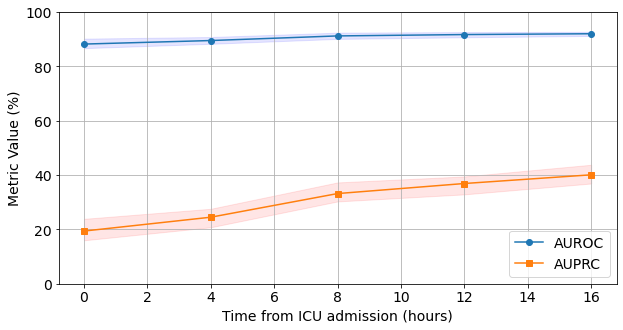

In [250]:
import matplotlib.pyplot as plt

# 绘制 results_positive
plt.figure(figsize=(10, 5))
times = list(results_positive.keys())
auroc_values = [x['AUROC'][0] for x in results_positive.values()]
auroc_conf_intervals = [x['AUROC'][1] for x in results_positive.values()]
auprc_values = [x['AUPRC'][0] for x in results_positive.values()]
auprc_conf_intervals = [x['AUPRC'][1] for x in results_positive.values()]

# 绘制 AUROC 和其置信区间
plt.plot(times, auroc_values, marker='o', label='AUROC')
plt.fill_between(times, [ci[0] for ci in auroc_conf_intervals], [ci[1] for ci in auroc_conf_intervals], color='blue', alpha=0.1)

# 绘制 AUPRC 和其置信区间
plt.plot(times, auprc_values, marker='s', label='AUPRC')
plt.fill_between(times, [ci[0] for ci in auprc_conf_intervals], [ci[1] for ci in auprc_conf_intervals], color='red', alpha=0.1)

plt.xlabel('Time from ICU admission (hours)')
plt.ylabel('Metric Value (%)')
plt.ylim(0, 100)  # 设置纵坐标范围为 0 到 1
plt.legend()
plt.grid(True)
plt.show()


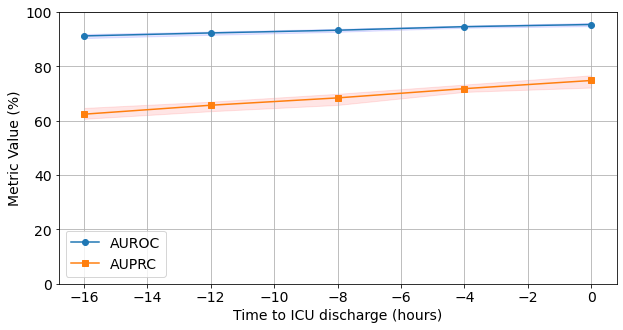

In [251]:
# 绘制 results_negative
plt.figure(figsize=(10, 5))
# 注意：为了从 -60 开始画，我们需要对 keys 进行排序
negative_keys_sorted = sorted(results_negative.keys())
auroc_values = [results_negative[k]['AUROC'][0] for k in negative_keys_sorted]
auroc_conf_intervals = [results_negative[k]['AUROC'][1] for k in negative_keys_sorted]
auprc_values = [results_negative[k]['AUPRC'][0] for k in negative_keys_sorted]
auprc_conf_intervals = [results_negative[k]['AUPRC'][1] for k in negative_keys_sorted]

# 绘制 AUROC 和其置信区间
plt.plot(negative_keys_sorted, auroc_values, marker='o', label='AUROC')
plt.fill_between(negative_keys_sorted, [ci[0] for ci in auroc_conf_intervals], [ci[1] for ci in auroc_conf_intervals], color='blue', alpha=0.1)

# 绘制 AUPRC 和其置信区间
plt.plot(negative_keys_sorted, auprc_values, marker='s', label='AUPRC')
plt.fill_between(negative_keys_sorted, [ci[0] for ci in auprc_conf_intervals], [ci[1] for ci in auprc_conf_intervals], color='red', alpha=0.1)

plt.xlabel('Time to ICU discharge (hours)')
plt.ylabel('Metric Value (%)')
plt.ylim(0, 100)  # 设置纵坐标范围为 0 到 1
plt.legend()
plt.grid(True)
plt.show()

### 亚组分析

In [120]:
import pandas as pd

In [254]:
ds = pd.read_csv("/home/luojiawei/pengxiran_project/结果文件夹/模型性能/in_hospital_death_post.csv",header=0)
ds_op = pd.read_csv("/home/luojiawei/pengxiran_project_data/inspire-a-publicly-available-research-dataset-for-perioperative-medicine-1.2/operations_derived.csv",header=0).loc[:,["op_id","type_name","asa"]]

In [255]:
ds.head()
# ds.shape

,all_id,y_pred_prob_0,y_true
0,400011247,0.017114,0.0
1,400018805,0.985015,0.0
2,400021263,0.247269,0.0
3,400029390,0.465637,0.0
4,400036055,0.996663,0.0


In [256]:
ds_op.head()

,op_id,type_name,asa
0,408038149,Central_Nervous_System_and_Cranial_Nerves,1.0
1,454625704,Central_Nervous_System_and_Cranial_Nerves,1.0
2,408213193,Central_Nervous_System_and_Cranial_Nerves,1.0
3,452356258,Central_Nervous_System_and_Cranial_Nerves,2.0
4,469321477,Central_Nervous_System_and_Cranial_Nerves,1.0


In [257]:
ds_op['asa_group'] = pd.cut(ds_op['asa'], bins=[0, 2, 5, 6], labels=['1-2', '3-5', '6'], right=True)

In [258]:
# 合并数据集
merged_ds = pd.merge(ds, ds_op, how='left', left_on='all_id', right_on='op_id')


In [259]:
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np

def calculate_metrics_with_confidence(data, y_true, y_score, group_by_column, n_bootstraps=1000):
    results = {}
    grouped = data.groupby(group_by_column)
    
    for name, group in grouped:
        auroc_scores = []
        auprc_scores = []
        
        for _ in range(n_bootstraps):
            # Bootstrap sample
            sample = group.sample(n=len(group), replace=True)
            try:
                auroc_scores.append(roc_auc_score(sample[y_true], sample[y_score]))
                auprc_scores.append(average_precision_score(sample[y_true], sample[y_score]))
            except ValueError as e:
                if 'Only one class present in y_true' in str(e):
                    continue  # Skip this bootstrap sample if only one class is present
                else:
                    raise  # Re-raise the exception if it's not the expected "only one class" error
        
        # Calculate mean and 95% confidence intervals if scores were successfully added
        if auroc_scores and auprc_scores:
            auroc = np.mean(auroc_scores)
            auroc_conf = np.percentile(auroc_scores, [2.5, 97.5])
            auprc = np.mean(auprc_scores)
            auprc_conf = np.percentile(auprc_scores, [2.5, 97.5])
            
            results[name] = {
                'AUROC': (auroc, auroc_conf),
                'AUPRC': (auprc, auprc_conf)
            }
    
    return results


In [266]:
group_name = "type_name"
GN = "Surgery Type"

# group_name = "asa_group"
# GN = "ASA"
# 计算每个类型的指标
metrics_results = calculate_metrics_with_confidence(merged_ds, 'y_true', 'y_pred_prob_0', group_name, 50)

In [267]:
merged_ds[group_name].value_counts()

Head_and_Neck                                3347
Urinary_and_Reproductive_Systems             3222
Skin_and_Soft_Tissue                         2711
Gastrointestinal_System                      2202
Bones_and_Joints                             1938
Other                                        1357
Hepatobiliary_System_and_Pancreas            1240
Endocrine_System                              952
Respiratory_System                            922
Central_Nervous_System_and_Cranial_Nerves     906
Peripheral_Vascular_System                    643
Heart_and_Great_Vessels                       548
Lymphatic_and_Hemic_Systems                   279
Name: type_name, dtype: int64

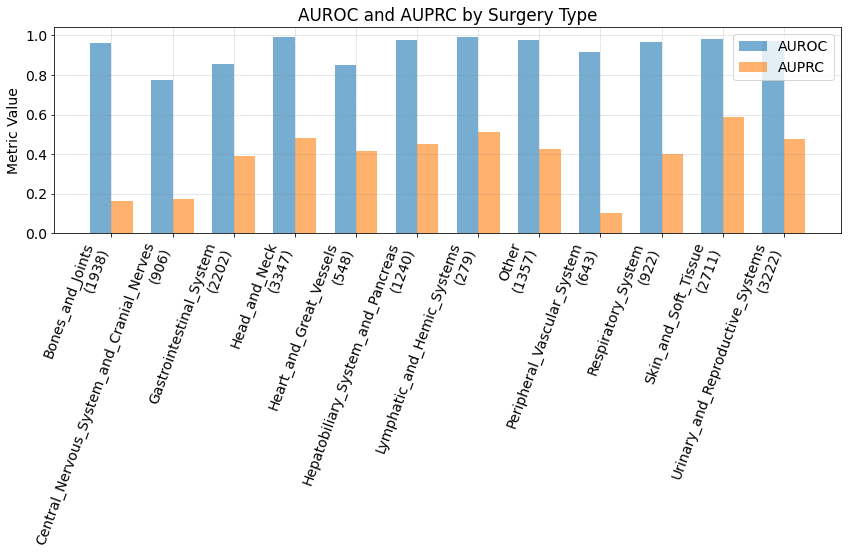

In [268]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制图表
fig, ax = plt.subplots(figsize=(12, 8))

type_names = list(metrics_results.keys())
auroc_values = [metrics_results[name]['AUROC'][0] for name in type_names]
auprc_values = [metrics_results[name]['AUPRC'][0] for name in type_names]

# 计算每个 ASA 类型的样本量
type_counts = merged_ds[group_name].value_counts().sort_index()

# 生成包含样本量的 type_names
type_names = [f"{x}\n({count})" for x, count in zip(metrics_results.keys(), type_counts.reindex(metrics_results.keys()).fillna(0).astype(int))]

# 设置柱子的宽度和位置
bar_width = 0.35  # 柱子的宽度
index = np.arange(len(type_names))  # type_names 的索引数组

# 绘制柱状图
rects1 = ax.bar(index - bar_width/2, auroc_values, bar_width, label='AUROC', alpha=0.6)
rects2 = ax.bar(index + bar_width/2, auprc_values, bar_width, label='AUPRC', alpha=0.6)

ax.set_ylabel('Metric Value')
ax.set_title(f'AUROC and AUPRC by {GN}')
ax.set_xticks(index)
ax.set_xticklabels(type_names, ha='right')  # 设置 x 轴标签的对齐方式为右对齐
ax.legend()

# 添加灰色的网格线
ax.grid(True, color='gray', linestyle='--', linewidth=0.5, alpha=0.5, zorder=0)

plt.xticks(rotation=70)
plt.tight_layout()
plt.show()

In [269]:
# 将 metrics_results 转换为 DataFrame 并保存到 CSV 文件
metrics_df = pd.DataFrame([
    {
        'Group': group,
        'AUROC': f"{metrics['AUROC'][0]:.4f} ({metrics['AUROC'][1][0]:.4f}, {metrics['AUROC'][1][1]:.4f})",
        'AUPRC': f"{metrics['AUPRC'][0]:.4f} ({metrics['AUPRC'][1][0]:.4f}, {metrics['AUPRC'][1][1]:.4f})"
    }
    for group, metrics in metrics_results.items()
])


In [270]:
metrics_df

,Group,AUROC,AUPRC
0,Bones_and_Joints,"0.9617 (0.9409, 0.9738)","0.1647 (0.0742, 0.2694)"
1,Central_Nervous_System_and_Cranial_Nerves,"0.7773 (0.6033, 0.9426)","0.1722 (0.0213, 0.5060)"
2,Gastrointestinal_System,"0.8563 (0.7535, 0.9411)","0.3897 (0.1964, 0.6400)"
3,Head_and_Neck,"0.9899 (0.9770, 1.0000)","0.4807 (0.0431, 1.0000)"
4,Heart_and_Great_Vessels,"0.8521 (0.7539, 0.9854)","0.4155 (0.2110, 0.6880)"
5,Hepatobiliary_System_and_Pancreas,"0.9753 (0.9601, 0.9910)","0.4525 (0.2077, 0.7927)"
6,Lymphatic_and_Hemic_Systems,"0.9930 (0.9820, 1.0000)","0.5126 (0.1667, 1.0000)"
7,Other,"0.9768 (0.9653, 0.9876)","0.4240 (0.2262, 0.6777)"
8,Peripheral_Vascular_System,"0.9149 (0.7692, 0.9818)","0.1023 (0.0067, 0.2487)"
9,Respiratory_System,"0.9685 (0.9403, 0.9912)","0.3984 (0.1619, 0.6538)"


In [271]:
metrics_df.to_csv("/home/luojiawei/pengxiran_project/结果文件夹/性能表格/subgroup_analysis_with_surg_in_hospital_death_post.csv", index=False)